# Does everything to run entropy and creates slurm files to submit for all diploid likelihoods from bcftools for both *tridentata* and *vayesana*

Goal is 4 chains k=2-7.

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
root = '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2'

In [4]:
cd $root

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2


### Create mgpl & pntest files with associated dir 

In [5]:
ent_dir =os.path.join(root,'entropy')
assert ent_dir

In [6]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy


In [7]:
!gunzip 'final_snps.recode.vcf.gz'

In [8]:
vcf = 'final_snps.recode.vcf'
vcf

'final_snps.recode.vcf'

In [9]:
perl_mpgl = '/data/gpfs/home/tfaske/g/src/perl_scripts/vcf2mpgl_milkweed.pl'
perl_mean = '/data/gpfs/home/tfaske/g/src/perl_scripts/gl2genest_milkweed.pl'

In [10]:
!perl $perl_mpgl $vcf

Number of loci: 13003; number of individuals 397


In [11]:
mpgl = 'final_snps.recode.mpgl'

In [12]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [13]:
%load_ext rpy2.ipython

In [20]:
%%R
require(readr)
require(MASS)
require(LEA)
require(ggplot2)
require(ggsci)
require(patchwork)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy')

R[write to console]: Loading required package: LEA



In [21]:
%%R
#create Pop_ID file 

indv<-read.table("../filtering/final_snps.recode.vcf.012.indv",sep="\t")

Sp <- rep(NA,times=nrow(indv))
Ploidy <- rep(NA,times=nrow(indv))
Pop <- rep(NA,times=nrow(indv))
ID <- rep(NA,times=nrow(indv))
All <- rep(NA,times=nrow(indv))
for (i in 1:nrow(indv)){
  SpP <- unlist(strsplit(as.character(indv$V1[i]),"_"))[1]
  Sp[i] <- gsub('\\d','',SpP,perl=TRUE)
  Ploidy[i] <-  gsub('(\\D)','',SpP,perl=TRUE)
  Pop[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[2]
  ID[i] <- unlist(strsplit(as.character(indv$V1[i]),"_"))[3]
  All[i] <- as.character(indv$V1[i])
}
Pop_ID <- data.frame(Sp=Sp,Ploidy=Ploidy,Pop=Pop,ID=ID,All=All,
                     SpPloidy=paste0(Sp,Ploidy))

print(head(Pop_ID))

write.csv(Pop_ID,"Pop_ID.csv",row.names = FALSE)

  Sp Ploidy Pop ID       All SpPloidy
1 AT      2  BB 10 AT2_BB_10      AT2
2 AT      2  BB 11 AT2_BB_11      AT2
3 AT      2  BB 12 AT2_BB_12      AT2
4 AT      2  BB 13 AT2_BB_13      AT2
5 AT      2  BB 14 AT2_BB_14      AT2
6 AT      2  BB 15 AT2_BB_15      AT2


In [16]:
%%R
g <- read.table("pntest_mean_final_snps.recode.txt", header=F)
dim(g)

[1] 13003   397


In [22]:
%%R
Pop_ID <- read.csv("Pop_ID.csv")
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.12569 0.02958 0.01392 0.01094 0.00943 


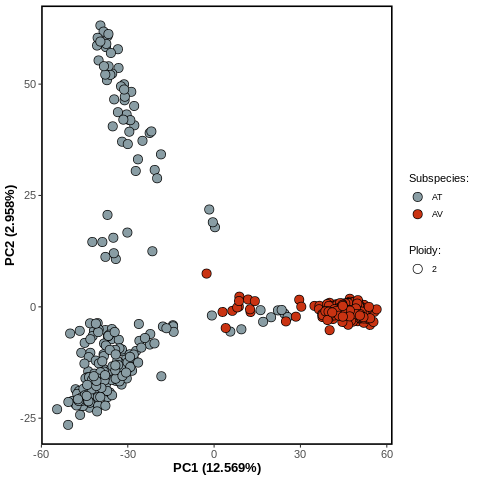

In [25]:
%%R
pca_df <- cbind(pca_df[,1:10],Pop_ID)

col2 <- c("#899DA4","#C93312")
ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=Sp,shape=as.character(Ploidy))) + 
  geom_point(colour='black',size = 4)+ #ggtitle("PCA ARTR all") +
  xlab(paste("PC",1," (",0.12569*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.02958*100,"%)",sep=""))  +
  scale_fill_manual(name='Subspecies:',values = col2) +
  scale_shape_manual(name='Ploidy:',values = c(21,24)) + 
  guides(fill = guide_legend(override.aes=list(pch=21))) + 
  theme_bw() + 
  theme(#legend.position = 'none',
    axis.text = element_text(size=11), 
    axis.title = element_text(size = 13, colour="black",face = "bold",vjust = 1),
    panel.border = element_rect(size = 1.5, colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())

In [26]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [27]:
%%R
######### create entropy header ####

Pop_ID_list <- Pop_ID$All

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [28]:
!head entropy_header.txt

397 13003                                                                                                                                                                                                                                                                                                                                                                                                            
AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14 AT2_BB_15 AT2_BB_16 AT2_BB_17 AT2_BB_1 AT2_BB_2 AT2_BB_3 AT2_BB_4 AT2_BB_5 AT2_BB_6 AT2_BB_7 AT2_BB_8 AT2_BB_9 AT2_BC_17 AT2_BC_18 AT2_BC_19 AT2_BC_20 AT2_BC_21 AT2_BC_22 AT2_BC_23 AT2_BT_1 AT2_BT_2 AT2_BT_3 AT2_BT_4 AT2_BT_57 AT2_BT_58 AT2_BT_59 AT2_BT_5 AT2_BT_60 AT2_BT_61 AT2_BT_62 AT2_BT_63 AT2_BT_64 AT2_BT_6 AT2_BT_7 AT2_BW_1 AT2_BW_65 AT2_BW_66 AT2_BW_67 AT2_BW_68 AT2_BW_69 AT2_BW_70 AT2_BW_71 AT2_BW_72 AT2_CB_24 AT2_CB_25 AT2_CB_26 AT2_CB_27 AT2_CB_28 AT2_CB_29 AT2_CB_30 AT2_CB_31 AT2_CB_32 AT2_DK_16 AT2_DK_17 AT2_DK_18 AT2_DK_19 A

In [29]:
!cat entropy_header.txt final_snps.recode.mpgl > entropy.mpgl

In [30]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy


In [31]:
!mkdir shdir

In [38]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
#account = 'cpu-s1-bionres-0'
#partition = 'cpu-s1-bionres-0'
time = '6-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 16000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7]
chains = 4

In [39]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [40]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [41]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/ent

In [42]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [43]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/milkweed/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [44]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [45]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy


In [46]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5']

In [47]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [48]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

HDF5-DIAG: Error detected in HDF5 (1.10.5) thread 46912498158592:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1661 in H5F_open(): unable to read root group
    major: File accessibilty
    minor: Unable to open file
  #002: H5Groot.c line 239 in H5G_mkroot(): can't check if symbol table message exists
    major: Symbol table
    minor: Can't get value
  #003: H5Omessage.c line 883 in H5O_msg_exists(): unable to protect object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1059 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.

HDF5-DIAG: Error detected in HDF5 (1.10.5) thread 46912498158592:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1661 in H5F_open(): unable to read root group
    major: File accessibilty
    minor: Unable to open file
  #002: H5Groot.c line 239 in H5G_mkroot(): can't check if symbol table message exists
    major: Symbol table
    minor: Can't get value
  #003: H5Omessage.c line 883 in H5O_msg_exists(): unable to protect object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1059 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.

HDF5-DIAG: Error detected in HDF5 (1.10.5) thread 46912498158592:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1661 in H5F_open(): unable to read root group
    major: File accessibilty
    minor: Unable to open file
  #002: H5Groot.c line 239 in H5G_mkroot(): can't check if symbol table message exists
    major: Symbol table
    minor: Can't get value
  #003: H5Omessage.c line 883 in H5O_msg_exists(): unable to protect object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1059 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.

HDF5-DIAG: Error detected in HDF5 (1.10.5) thread 46912498158592:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1661 in H5F_open(): unable to read root group
    major: File accessibilty
    minor: Unable to open file
  #002: H5Groot.c line 239 in H5G_mkroot(): can't check if symbol table message exists
    major: Symbol table
    minor: Can't get value
  #003: H5Omessage.c line 883 in H5O_msg_exists(): unable to protect object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1059 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.

In [49]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt']

In [50]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 8471479.26
Effective number of parameters: 7698594.18
Model DIC: 16170073.44


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 9, chains = 1
Model deviance: 0.00
Effective number of parameters: 0.00
Model DIC: 0.00


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 8471646.19
Effective number of parameters: 7485784.25
Model DIC: 15957430.44


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 9, chains = 1
Model deviance: 0.00
Effective number of parameters: 0.00
Model DIC: 0.00


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 8227776.34
Effective number of parameters: 8458046.06
Model DIC: 16685822.40


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 8158802.11
Ef

In [51]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,16170073.44,4
1,7,0.00,2
2,2,15957430.44,1
3,6,0.00,1
4,3,16685822.40,2


In [52]:
dic_df.to_csv('dic_list.csv')

In [53]:
dic_sum = dic_df.groupby('k').describe().DIC

In [54]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
5,4.0,0.0000,0.00000000,0.00,0.0000,0.000,0.00,0.00
6,4.0,0.0000,0.00000000,0.00,0.0000,0.000,0.00,0.00
7,4.0,0.0000,0.00000000,0.00,0.0000,0.000,0.00,0.00
2,4.0,15801791.6550,330674.22237435,15415462.89,15602015.6100,15810815.145,16010591.19,16170073.44
4,4.0,16618810.4175,166712.54973353,16504852.07,16520507.4275,16553058.270,16651361.26,16864273.06
3,4.0,16798452.6900,244753.71350629,16513412.40,16642719.9000,16812596.930,16968329.72,17055204.50


In [64]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [55]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

#!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

#!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

#!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 397, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 397, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 397, populations = 4, samples = 5000, chains = 4


In [56]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

#!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

#!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

#!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 397, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 397, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 397, populations = 4, samples = 5000, chains = 4


### make slurm script to make gprob file

    use all k and chains to make gprob

In [57]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy


In [58]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,6,7]

In [59]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [60]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [61]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_gprob_k6.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/entropy/shdir/run_gprob_k7.sh']

In [62]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [63]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

In [76]:
hdf5_files = []
for k in num_k:
    f = '../entropy_k' + str(k) + '_c*hdf5'
    hdf5_files.append(f)
hdf5_files

['../entropy_k2_c*hdf5',
 '../entropy_k3_c*hdf5',
 '../entropy_k4_c*hdf5',
 '../entropy_k6_c*hdf5',
 '../entropy_k7_c*hdf5']

In [77]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c*hdf5 ../entropy_k3_c*hdf5 ../entropy_k4_c*hdf5 ../entropy_k6_c*hdf5 ../entropy_k7_c*hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [78]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [79]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [80]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 
    cd /data/gpfs/home/tfaske/d/sagebrush/SNPcall/AT2/entropy
    source activate entropy
    sbatch run_gprob.sh

In [ ]:
#gprobs
#!$estpost *k2*.hdf5 -p gprob -s 0 -o gprob2.txt

#!$estpost *k3*.hdf5 -p gprob -s 0 -o gprob3.txt

#!$estpost *k4*.hdf5 -p gprob -s 0 -o gprob4.txt

#!$estpost *k5*.hdf5 -p gprob -s 0 -o gprob5.txt